In [16]:
import sent2vec
cleaned_expression_data = [line.strip().split("\t") for line in open("../../gold_standard_sentences/GROBID_clean_with_negative_otherexpr.csv")]
cleaned_kinaseact_data = [line.strip().split("\t") for line in open("../../gold_standard_sentences/GROBID_clean_with_negative_kinaseact.csv")]
cleaned_expression_data = [[row[0], int(row[1]), row[2]] for row in cleaned_expression_data]
cleaned_kinaseact_data = [[row[0], int(row[1]), row[2]] for row in cleaned_kinaseact_data]
bio_sent_vec_model_location = "../../biosentvec/model.bin"

In [17]:
model_path = bio_sent_vec_model_location
biosentvec_model = sent2vec.Sent2vecModel()
try:
    biosentvec_model.load_model(model_path)
except Exception as e:
    print(e)
print('model successfully loaded')

model successfully loaded


In [18]:
corpus_expr = biosentvec_model.embed_sentences([row[0] for row in cleaned_expression_data])
corpus_kinaseact = biosentvec_model.embed_sentences([row[0] for row in cleaned_kinaseact_data])

In [19]:
import umap

umap_reducer = umap.UMAP(metric='cosine')
corpus_expr_2d = umap_reducer.fit_transform(corpus_expr)
corpus_kinaseact_2d = umap_reducer.fit_transform(corpus_kinaseact)

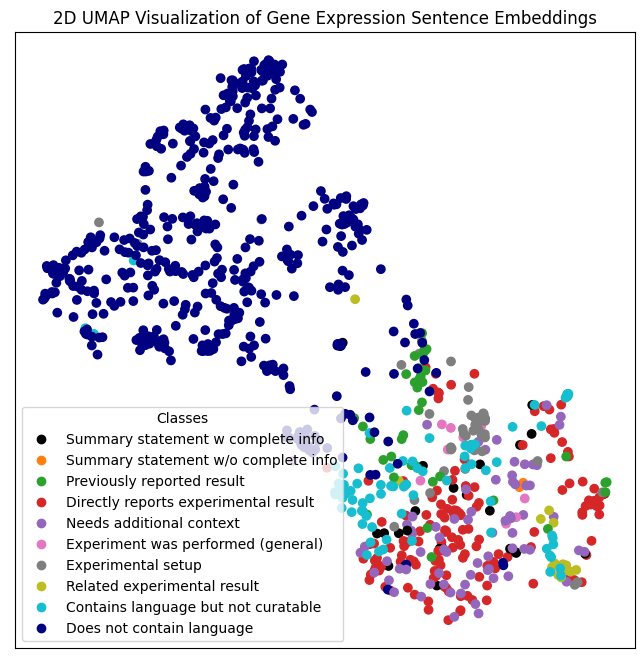

In [20]:
from matplotlib.colors import ListedColormap
from matplotlib import pyplot as plt

colors = ListedColormap(['black','tab:orange','tab:green','tab:red','tab:purple','tab:brown','tab:pink','tab:grey','tab:olive','tab:cyan', 'navy'])
values = [int(row[1]) for row in cleaned_expression_data]
classes = ['Summary statement w complete info', 'Summary statement w/o complete info', 'Previously reported result', 'Directly reports experimental result', 'Needs additional context', 'Experiment was performed (general)', 'Experimental setup', 'Related experimental result', 'Contains language but not curatable', 'Does not contain language']
fig, ax = plt.subplots(figsize=(8,8))
scatter = ax.scatter(x=list(corpus_expr_2d[:,0]), y=list(corpus_expr_2d[:,1]), c=values, cmap=colors)
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Gene Expression Sentence Embeddings")
legend = ax.legend(handles=scatter.legend_elements()[0], loc="lower left", title="Classes", labels=classes)

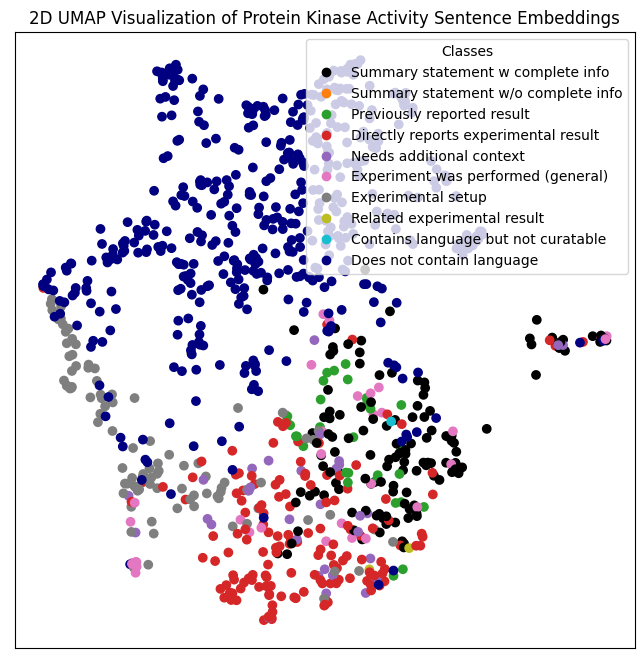

In [21]:
values = [int(row[1]) for row in cleaned_kinaseact_data]
fig, ax = plt.subplots(figsize=(8, 8))
plt.xticks([])
plt.yticks([])
plt.title("2D UMAP Visualization of Protein Kinase Activity Sentence Embeddings")
ax.scatter(x=list(corpus_kinaseact_2d[:,0]), y=list(corpus_kinaseact_2d[:,1]), c=values, cmap=colors)
legend = ax.legend(handles=scatter.legend_elements()[0], loc="upper right", title="Classes", labels=classes)

# classifiers

In [22]:
from random import shuffle
from sklearn.neural_network import MLPClassifier
import math

converted_corpus_expr = corpus_expr
converted_corpus_kinaseact = corpus_kinaseact
indices_expr = [i for i in range(len(corpus_expr))]
shuffle(indices_expr)
training_size_expr = math.ceil(len(corpus_expr) * 0.8)
training_indices_expr = indices_expr[0:training_size_expr]
test_indices_expr = indices_expr[training_size_expr:]
training_set_data_expr = [converted_corpus_expr[index] for index in training_indices_expr]
indices_kinaseact = [i for i in range(len(corpus_kinaseact))]
shuffle(indices_kinaseact)
training_size_kinaseact = math.ceil(len(corpus_kinaseact) * 0.8)
training_indices_kinaseact = indices_kinaseact[0:training_size_kinaseact]
test_indices_kinaseact = indices_kinaseact[training_size_kinaseact:]
training_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in training_indices_kinaseact]
base_clf = MLPClassifier(hidden_layer_sizes=(10, 10), alpha=0.1)

# prediction

## binary
### 1. Classifier that extracts sentences that contain all the information necessary to make an annotation.

In [23]:
from sklearn.metrics import precision_recall_fscore_support as score
test_set_data_expr = [converted_corpus_expr[index] for index in test_indices_expr]
test_set_data_kinaseact = [converted_corpus_kinaseact[index] for index in test_indices_kinaseact]

In [24]:
import joblib
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 3] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.89032258 0.625     ]
recall: [0.92       0.54054054]
fscore: [0.90491803 0.57971014]
support: [150  37]


In [25]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average='weighted')
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.8378255994479904
recall: 0.8449197860962567
fscore: 0.840572087060704
support: None


In [26]:
final_set_classes_expr = [1 if sentence[1] in [0, 3] else 0 for sentence in cleaned_expression_data]
clf = base_clf.fit(converted_corpus_expr, final_set_classes_expr)
joblib.dump(clf, '../../classifiers/GROBID_all_info_expression.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../../classifiers/GROBID_all_info_expression.joblib']

In [27]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 3] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.94652406 0.5       ]
recall: [0.96721311 0.375     ]
fscore: [0.95675676 0.42857143]
support: [183  16]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [28]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9106226318759574
recall: 0.9195979899497487
fscore: 0.9142895946916048
support: None


In [29]:
final_set_classes_kinase = [1 if sentence[1] in [0, 3] else 0 for sentence in cleaned_kinaseact_data]
clf = base_clf.fit(converted_corpus_kinaseact, final_set_classes_kinase)
joblib.dump(clf, '../../classifiers/GROBID_all_info_kinase.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../../classifiers/GROBID_all_info_kinase.joblib']

### 2. Classifier that extracts sentences that contain curatable information

In [30]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] in [0, 1, 3, 4] else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.90647482 0.77083333]
recall: [0.91970803 0.74      ]
fscore: [0.91304348 0.75510204]
support: [137  50]


In [31]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


precision: 0.8702070429218123
recall: 0.8716577540106952
fscore: 0.8708131473933447
support: None


In [32]:
final_set_classes_expression = [1 if sentence[1] in [0, 1, 3, 4] else 0 for sentence in cleaned_expression_data]
clf = base_clf.fit(converted_corpus_expr, final_set_classes_expression)
joblib.dump(clf, '../../classifiers/GROBID_curatable_expression.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../../classifiers/GROBID_curatable_expression.joblib']

In [44]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] in [0, 1, 3, 4] and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93888889 0.47368421]
recall: [0.94413408 0.45      ]
fscore: [0.94150418 0.46153846]
support: [179  20]


In [34]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9056362228576893
recall: 0.9095477386934674
fscore: 0.9074186723089129
support: None


In [35]:
final_set_classes_kinase = [1 if sentence[1] in [0, 1, 3, 4] and sentence[2] in ['positive', 'both'] else 0 for sentence in cleaned_kinaseact_data]
clf = base_clf.fit(converted_corpus_kinaseact, final_set_classes_kinase)
joblib.dump(clf, '../../classifiers/GROBID_curatable_kinase.joblib')

/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


['../../classifiers/GROBID_curatable_kinase.joblib']

### 3. Classifier that extracts sentences that contain language

In [36]:
training_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in training_indices_expr]
test_set_classes_expr = [1 if cleaned_expression_data[index][1] < 9 else 0 for index in test_indices_expr]
clf = base_clf.fit(training_set_data_expr, training_set_classes_expr)
test_predictions_expr = list(clf.predict(test_set_data_expr))
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.94949495 0.97727273]
recall: [0.97916667 0.94505495]
fscore: [0.96410256 0.96089385]
support: [96 91]


In [37]:
precision, recall, fscore, support = score(test_set_classes_expr, test_predictions_expr, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9630124777183601
recall: 0.9625668449197861
fscore: 0.9625411066094602
support: None


In [38]:
final_set_classes_expression = [1 if sentence[1] < 9 else 0 for sentence in cleaned_expression_data]
clf = base_clf.fit(converted_corpus_expr, final_set_classes_expression)
joblib.dump(clf, '../../classifiers/GROBID_language_expression.joblib')

['../../classifiers/GROBID_language_expression.joblib']

In [39]:
training_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in training_indices_kinaseact]
test_set_classes_kinaseact = [1 if cleaned_kinaseact_data[index][1] < 9 and cleaned_kinaseact_data[index][2] in ['positive', 'both'] else 0 for index in test_indices_kinaseact]
clf = base_clf.fit(training_set_data_kinaseact, training_set_classes_kinaseact)
test_predictions_kinaseact = list(clf.predict(test_set_data_kinaseact))
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: [0.93442623 0.625     ]
recall: [0.96610169 0.45454545]
fscore: [0.95       0.52631579]
support: [177  22]


/home/valerio/workspace/caltech/sentence_classification/venv/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:686: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(


In [40]:
precision, recall, fscore, support = score(test_set_classes_kinaseact, test_predictions_kinaseact, average="weighted")
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))

precision: 0.9002183046379438
recall: 0.9095477386934674
fscore: 0.9031605395398042
support: None


In [41]:
final_set_classes_kinase = [1 if sentence[1] < 9 and sentence[2] in ['positive', 'both'] else 0 for sentence in cleaned_kinaseact_data]
clf = base_clf.fit(converted_corpus_kinaseact, final_set_classes_kinase)
joblib.dump(clf, '../../classifiers/GROBID_language_kinase.joblib')

['../../classifiers/GROBID_language_kinase.joblib']

# Feature analysis for positive sentences

## expression

(0.0, 510.0)

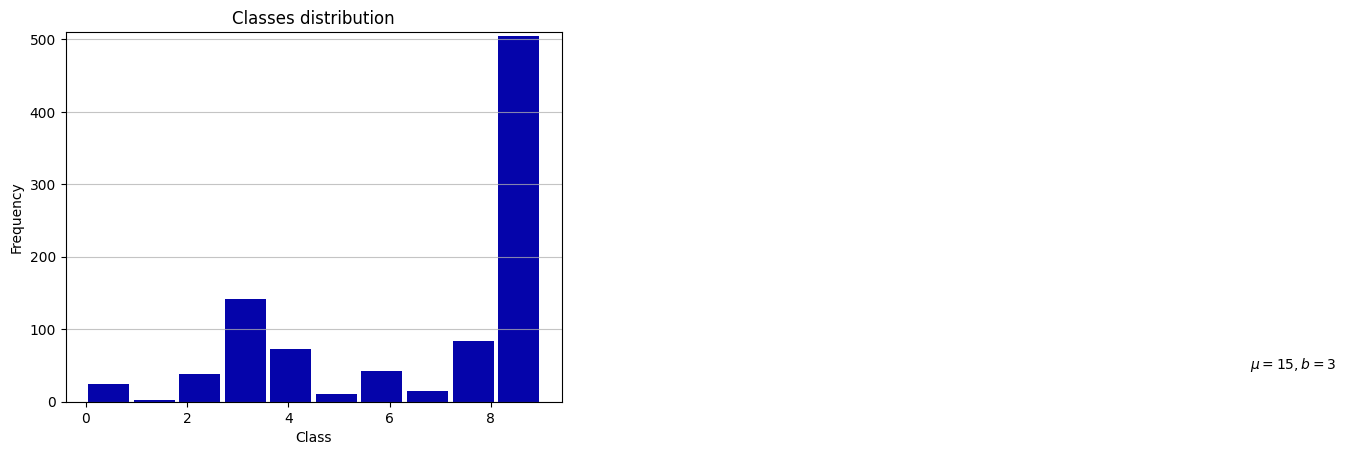

In [42]:
import matplotlib.pyplot as plt
import numpy as np

n, bins, patches = plt.hist(x=[r[1] for r in cleaned_expression_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)

# kinase act

(0.0, 510.0)

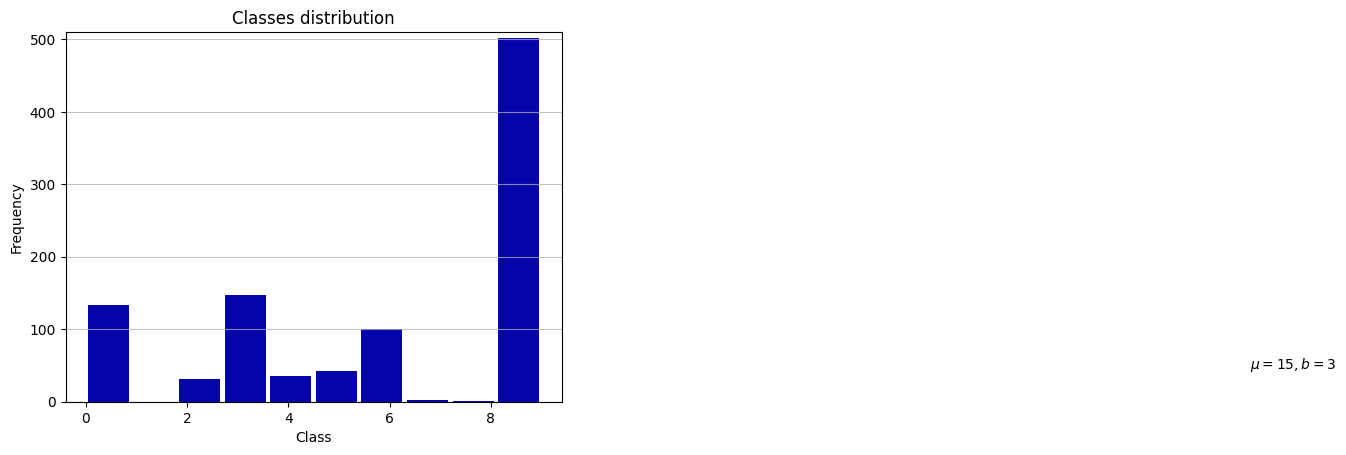

In [43]:
n, bins, patches = plt.hist(x=[r[1] for r in cleaned_kinaseact_data], bins=10, color='#0504aa',
                            alpha=1, rwidth=0.9)
plt.grid(axis='y', alpha=0.75)
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.title('Classes distribution')
plt.text(23, 45, r'$\mu=15, b=3$')
maxfreq = n.max()
# Set a clean upper y-axis limit.
plt.ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)